Goal of this notebook: implement some basic RNN/LSTM/GRU to _forecast_ trajectories based on VIRAT and/or the custom _hof_ dataset.

Somewhat based on [test_custom_rnn](test_custom_rnn.ipynb) for the network and [test_trajectron_maps](test_trajectron_maps.ipynb) for the dataloading. And many thanks to [seq2seq-time-series-forecasting-fully-recurrent](https://github.com/maxbrenner-ai/seq2seq-time-series-forecasting-fully-recurrent/blob/main/notebook.ipynb) by maxbrenner-ai.

TODO: Look into  [TimeSeriesTransformerForPrediction](https://huggingface.co/docs/transformers/main/model_doc/time_series_transformer#transformers.TimeSeriesTransformerForPrediction) from huggingface

In [3]:

from pathlib import Path
from trap.frame_emitter import Camera
from trap.utils import ImageMap
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
import torch.nn as nn

from torch import optim
import torch.nn.functional as F

# Configuration

Track dataset options

In [4]:

path = Path("EXPERIMENTS/raw/hof3/")
calibration_path = Path("../DATASETS/hof3/calibration.json")
homography_path = Path("../DATASETS/hof3/homography.json")
device = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
camera = Camera.from_paths(calibration_path, homography_path, 12)

# when using a map encoder:
image_path = Path("../DATASETS/hof3/map-undistorted-H-2.png")
assert image_path.exists()

CACHE_DIR = Path("/tmp/cache-custom-rnn")

Network and training parameters

In [5]:
input_seq_length = 36
output_seq_length = 36

lr = 0.00005
num_epochs = 100
batch_size = 512
hidden_size = 32
num_gru_layers = 1
grad_clip = 1.0
scheduled_sampling_decay = 10
dropout = 0.

# As opposed to point-wise (assumes Gaussian)
probabilistic = True

use_attention = True

In [6]:
# decay is used to determine "forced teacher" or 'freerunning' in recurrent learning
# inverse sigmoid decay from https://arxiv.org/pdf/1506.03099.pdf
import math


def inverse_sigmoid_decay(decay):
    def compute(indx):
        return decay / (decay + math.exp(indx / decay))
    return compute
calc_teacher_force_prob = inverse_sigmoid_decay(scheduled_sampling_decay)

f'At epoch 0 teacher force prob will be {calc_teacher_force_prob(0)}', \
f'At epoch {num_epochs} teacher force prob will be {calc_teacher_force_prob(num_epochs-1)}'


('At epoch 0 teacher force prob will be 0.9090909090909091',
 'At epoch 100 teacher force prob will be 0.0005014951969411607')

Map encoding as used in Trajectron++.

(1440, 2560, 3)
(72, 128, 3)


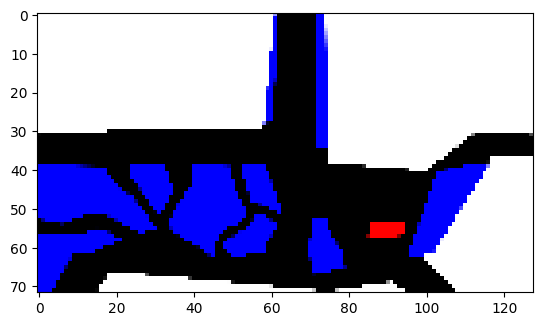

In [7]:
homography_matrix = np.array([
            [5, 0,0],
            [0, 5,0],
            [0,0,1],
        ]) # 100 scale
img = cv2.imread(image_path)
print(img.shape)
img = cv2.resize(img, (img.shape[1]//20, img.shape[0]//20))

print(img.shape)
imgmap = ImageMap(img, homography_matrix, "hof3-undistorted-H-2")
# img = cv2.imread(image_path)

plt.imshow(img)


In [8]:
from trap.tracker import TrackReader


reader = TrackReader(path, camera.fps, exclude_whitelisted = False, include_blacklisted=False)

In [9]:
from typing import List
from trap.frame_emitter import Track
from trap.tracker import FinalDisplacementFilter

# 
# make sure we have all points for all tracks
tracks: List[Track] = [t.get_with_interpolated_history() for t in reader]
# t = Smoother().smooth_track(t)
track_filter = FinalDisplacementFilter(2)
tracks = track_filter.apply(tracks, camera)

In [10]:
def flatten_multicolumn(df : pd.DataFrame):
    "Multicolumn index to a flattended index, e.g. velocity_x"
    df.columns = ['_'.join(col).strip() for col in df.columns.values]

def preprocess_track(track: Track, camera: Camera) -> pd.DataFrame:
    df = track.to_dataframe(camera)

    flatten_multicolumn(df)
        
    df['dx'] = df['velocity_x'] / track.fps
    df['dy'] = df['velocity_y'] / track.fps
    return df

In [11]:
# track_dfs = [t.to_dataframe(camera) for t in tracks[:10]]
# def flatten_multicolumn(df : pd.DataFrame):
#     "Multicolumn index to a flattended index, e.g. velocity_x"
#     df.columns = ['_'.join(col).strip() for col in df.columns.values]

# for df in track_dfs:
#     flatten_multicolumn(df)
    
# for df, track in zip(track_dfs, tracks):
#     df['dx'] = df['velocity_x'] / track.fps
#     df['dy'] = df['velocity_y'] / track.fps
    

In [12]:
# for track in tracks:
#     history = track.get_projected_history(None, camera)
#     points = imgmap.to_map_points(history)
#     # print(history, points)
#     break


In [13]:
target_indices = [0, 1]
in_fields = [ 'dx', 'dy', 'position_x', 'position_y', 'velocity_x', 'velocity_y', 'acceleration_x', 'acceleration_y'] #, 'dt'] (WARNING: dt column contains NaN)
# out_fields = ['v', 'heading']
# velocity cannot be negative, and heading is circular (modulo), this makes it harder to optimise than a linear space, so try to use components
# an we can use simple MSE loss (I guess?)
out_fields = ['dx', 'dy']
# SAMPLE_STEP = 5 # 1/5, for 12fps leads to effectively 12/5=2.4fps
# GRID_SIZE = 2 # round items on a grid of 2 points per meter (None to disable rounding)
# window = 8 #int(FPS*1.5 / SAMPLE_STEP)

In [14]:
# Set device
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(device)

# Hyperparameters
input_size = len(in_fields)   #in_d
# hidden_size = 64                       # hidden_d
# num_layers = 1                         # num_hidden
output_size = len(out_fields) # out_d
# learning_rate = 0.005 #0.01 #0.005
# batch_size = 512
num_epochs


100

In [15]:
cache_path = Path(CACHE_DIR)
cache_path.mkdir(parents=True, exist_ok=True)

In [16]:
# from trap.tools import load_tracks_from_csv
from trap.tools import filter_short_tracks, normalise_position

# data= load_tracks_from_csv(Path(SRC_CSV), FPS, GRID_SIZE, SAMPLE_STEP )

In [17]:
# create x-norm, y_norm columns
# data, mu, std = normalise_position(data)
# data = filter_short_tracks(data, window+1)

Create splits, 80% of the tracks to testing.

In [18]:
np.random.shuffle(tracks)
test_offset_idx = int(len(tracks) * .8)

training_tracks, test_tracks = tracks[:test_offset_idx], tracks[test_offset_idx:]
# print(len(training_tracks))
print(f"{len(training_tracks)} training tracks, {len(test_tracks)} test tracks")

1903 training tracks, 476 test tracks


In [19]:
# # track_ids = data.index.unique('track_id').to_numpy()
# track_ids = reader.track_ids()
# np.random.shuffle(track_ids)
# test_offset_idx = int(len(track_ids) * .8)
# training_ids, test_ids = track_ids[:test_offset_idx], track_ids[test_offset_idx:]
# print(f"{len(training_ids)} training tracks, {len(test_ids)} test tracks")

In [20]:
# import random
# def plot_track(track_id: int):
#     ax = plt.scatter(
#         data.loc[track_id,:]['x_norm'],
#         data.loc[track_id,:]['y_norm'],
#         marker="*") 
#     plt.plot(
#         data.loc[track_id,:]['x_norm'],
#         data.loc[track_id,:]['y_norm']
#     )

# # print(filtered_data.loc[track_id,:]['proj_x'])
# # _track_id = 2188
# _track_id = random.choice(track_ids)
# print(_track_id)
# plot_track(_track_id)

# for track_id in random.choices(track_ids, k=100):
#     plot_track(track_id)
    
# # print(mean_x, mean_y)

Now make the dataset:

In [21]:
# print(len(reader.get("24229").history))

In [22]:
from copy import deepcopy
from pandas import DataFrame
from tqdm import tqdm



def create_dataset(tracks: list[Track], input_seq_length: int, output_seq_length: int, in_fields: list[str], out_fields: list[str], camera: Camera, only_last=False, device='cpu') -> dict[str, torch.Tensor]:
    encoder_X, decoder_X, decoder_y, = [], [], []
    # factor = SAMPLE_STEP if SAMPLE_STEP is not None else 1
    for track in tqdm(tracks):
        # track = reader.get(track_id)
        if len(track.history) < 2:
            print(track.track_id, "too short")
        df: DataFrame = preprocess_track(track, camera)
        # df = data.loc[track_id]
        # print(df)
        # start_frame = min(df.index.tolist())
        for timestep in range(df.shape[0] - (input_seq_length + output_seq_length) + 1):

            # enc_inputs: (input seq len, num features)
            # print(df[timestep:timestep+input_seq_length][['velocity_x', 'velocity_y']])
            enc_inputs_at_t = deepcopy(df[timestep : timestep + input_seq_length][in_fields])
            dec_at_t = deepcopy(df[timestep + input_seq_length - 1 : timestep + input_seq_length + output_seq_length])
            # dec_targets: (output seq len, num features)
            dec_inputs_at_t = deepcopy(dec_at_t[:-1][in_fields])
            # dec_targets: (output seq len, num targets)
            dec_targets_at_t = deepcopy(dec_at_t[1:][out_fields])
            
        # # for step in range(len(df)-window-1):
        #     i = int(start_frame) + (step*factor)
        #     # print(step, int(start_frame), i)
        #     feature = df.loc[i:i+(window*factor)][in_fields]
        #     # target = df.loc[i+1:i+window+1][out_fields]
        #     # print(i, window*factor, factor, i+window*factor+factor, df['idx_in_track'])
        #     # print(i+window*factor+factor)
        #     if only_last:
        #         target = df.loc[i+window*factor+factor][out_fields]
        #     else:
        #         target = df.loc[i+factor:i+window*factor+factor][out_fields]

            encoder_X.append(enc_inputs_at_t.values)
            decoder_X.append(dec_inputs_at_t.values)
            decoder_y.append(dec_targets_at_t.values)
            
    return {'enc_inputs': torch.tensor(np.array(encoder_X), device=device, dtype=torch.float), 
          'dec_inputs': torch.tensor(np.array(decoder_X), device=device, dtype=torch.float), 
          'dec_outputs': torch.tensor(np.array(decoder_y), device=device, dtype=torch.float)}

train_data = create_dataset(training_tracks, input_seq_length, output_seq_length, in_fields, out_fields, camera, False, device)
test_data = create_dataset(test_tracks, input_seq_length, output_seq_length, in_fields, out_fields, camera, False, device)


  0%|          | 0/1903 [00:00<?, ?it/s]

100%|██████████| 476/476 [00:40<00:00, 11.71it/s]


In [23]:
# X_train, y_train = X_train.to(device=device), y_train.to(device=device)
# X_test, y_test = X_test.to(device=device), y_test.to(device=device)

In [24]:
# from torch.utils.data import TensorDataset, DataLoader
# dataset_train = TensorDataset(X_train, y_train)
# loader_train = DataLoader(dataset_train, shuffle=True, batch_size=batch_size)
# dataset_test = TensorDataset(X_test, y_test)
# loader_test = DataLoader(dataset_test, shuffle=False, batch_size=batch_size)

Model give output for all timesteps, this should improve training. But we use only the last timestep for the prediction process

# Seq2seq encoder/decoder with attention

In [25]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_gru_layers, dropout_p=0.1):
        super().__init__()
        self.hidden_size = hidden_size

        # self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(input_size, hidden_size, num_gru_layers, batch_first=True)
        # self.dropout = nn.Dropout(dropout_p) # TODO)) How to bring this back, see 

    def forward(self, inputs):
        # inputs: (batch size, input seq len, num enc features)
        # embedded = self.dropout(self.embedding(input))

        # output: (batch size, input seq len, hidden size)
        # hidden: (num gru layers, batch size, hidden size)
        output, hidden = self.gru(inputs)
        return output, hidden


In [26]:
# Decoder superclass whose forward is called by Seq2Seq but other methods filled out by subclasses
import random


class DecoderBase(nn.Module):
    def __init__(self, device, dec_target_size, target_indices, dist_size, probabilistic):
        super().__init__()
        self.device = device
        self.target_indices = target_indices # indices of desired output in the training input vector, used for force teaching
        self.target_size = dec_target_size
        self.dist_size = dist_size
        self.probabilistic = probabilistic
    
    # Have to run one step at a time unlike with the encoder since sometimes not teacher forcing
    def run_single_recurrent_step(self, inputs, hidden, enc_outputs):
        raise NotImplementedError()
    
    def forward(self, inputs, hidden, enc_outputs, teacher_force_prob=None):
        # inputs: (batch size, output seq length, num dec features)
        # hidden: (num gru layers, batch size, hidden dim), ie the last hidden state
        # enc_outputs: (batch size, input seq len, hidden size)
        
        batch_size, dec_output_seq_length, _ = inputs.shape
        
        # Store decoder outputs
        # outputs: (batch size, output seq len, num targets, num dist params)
        outputs = torch.zeros(batch_size, dec_output_seq_length, self.target_size, self.dist_size, dtype=torch.float).to(self.device)

        # curr_input: (batch size, 1, num dec features)
        curr_input = inputs[:, 0:1, :]
        
        for t in range(dec_output_seq_length):
            # dec_output: (batch size, 1, num targets, num dist params)
            # hidden: (num gru layers, batch size, hidden size)
            dec_output, hidden = self.run_single_recurrent_step(curr_input, hidden, enc_outputs)
            # Save prediction
            outputs[:, t:t+1, :, :] = dec_output
            # dec_output: (batch size, 1, num targets)
            dec_output = Seq2Seq.sample_from_output(dec_output)
            
            # If teacher forcing, use target from this timestep as next input o.w. use prediction
            teacher_force: bool = random.random() < teacher_force_prob if teacher_force_prob is not None else False
            
            curr_input = inputs[:, t:t+1, :].clone()
            if not teacher_force:
                curr_input[:, :, self.target_indices] = dec_output
        return outputs

In [27]:
def layer_init(layer, w_scale=1.0):
    nn.init.kaiming_uniform_(layer.weight.data)
    layer.weight.data.mul_(w_scale)
    nn.init.constant_(layer.bias.data, 0.)
    return layer

In [28]:

class DecoderVanilla(DecoderBase):
    def __init__(self, dec_feature_size, dec_target_size, hidden_size, 
                 num_gru_layers, target_indices, dropout, dist_size,
                 probabilistic, device):
        super().__init__(device, dec_target_size, target_indices, dist_size, probabilistic)
        self.gru = nn.GRU(dec_feature_size, hidden_size, num_gru_layers, batch_first=True, dropout=dropout)
        self.out = layer_init(nn.Linear(hidden_size + dec_feature_size, dec_target_size * dist_size))
    
    def run_single_recurrent_step(self, inputs, hidden, enc_outputs):
        # inputs: (batch size, 1, num dec features)
        # hidden: (num gru layers, batch size, hidden size)
        
        output, hidden = self.gru(inputs, hidden)
        output = self.out(torch.cat((output, inputs), dim=2))
        output = output.reshape(output.shape[0], output.shape[1], self.target_size, self.dist_size)
        
        # output: (batch size, 1, num targets, num dist params)
        # hidden: (num gru layers, batch size, hidden size)
        return output, hidden



In [29]:
class Attention(nn.Module):
    def __init__(self, hidden_size, num_gru_layers):
        super().__init__()
        # NOTE: the hidden size for the output of attn (and input of v) can actually be any number  
        # Also, using two layers allows for a non-linear act func inbetween
        self.attn = nn.Linear(2 * hidden_size, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)
    
    def forward(self, decoder_hidden_final_layer, encoder_outputs):
        # decoder_hidden_final_layer: (batch size, hidden size)
        # encoder_outputs: (batch size, input seq len, hidden size)
        
        # Repeat decoder hidden state input seq len times
        hidden = decoder_hidden_final_layer.unsqueeze(1).repeat(1, encoder_outputs.shape[1], 1)
        
        # Compare decoder hidden state with each encoder output using a learnable tanh layer
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        
        # Then compress into single values for each comparison (energy)
        attention = self.v(energy).squeeze(2)
        
        # Then softmax so the weightings add up to 1
        weightings = F.softmax(attention, dim=1)
                
        # weightings: (batch size, input seq len)
        return weightings

In [30]:
class DecoderWithAttention(DecoderBase):
    def __init__(self, dec_feature_size, dec_target_size, hidden_size, 
                 num_gru_layers, target_indices, dropout, dist_size,
                 probabilistic, device):
        super().__init__(device, dec_target_size, target_indices, dist_size, probabilistic)
        self.attention_model = Attention(hidden_size, num_gru_layers)
        # GRU takes previous timestep target and weighted sum of encoder hidden states
        self.gru = nn.GRU(dec_feature_size + hidden_size, hidden_size, num_gru_layers, batch_first=True, dropout=dropout)
        # Output layer takes decoder hidden state output, weighted sum and decoder input
        # NOTE: Feeding decoder input into the output layer essentially acts as a skip connection
        self.out = layer_init(nn.Linear(hidden_size + hidden_size + dec_feature_size, dec_target_size * dist_size))

    def run_single_recurrent_step(self, inputs, hidden, enc_outputs):
        # inputs: (batch size, 1, num dec features)
        # hidden: (num gru layers, batch size, hidden size)
        # enc_outputs: (batch size, input seq len, hidden size)
        
        # Get attention weightings
        # weightings: (batch size, input seq len)
        weightings = self.attention_model(hidden[-1], enc_outputs)
        
        # Then compute weighted sum
        # weighted_sum: (batch size, 1, hidden size)
        weighted_sum = torch.bmm(weightings.unsqueeze(1), enc_outputs)
                
        # Then input into GRU
        # gru inputs: (batch size, 1, num dec features + hidden size)
        # output: (batch size, 1, hidden size)
        output, hidden = self.gru(torch.cat((inputs, weighted_sum), dim=2), hidden)
            
        # Get prediction
        # out input: (batch size, 1, hidden size + hidden size + num targets)
        output = self.out(torch.cat((output, weighted_sum, inputs), dim=2))
        output = output.reshape(output.shape[0], output.shape[1], self.target_size, self.dist_size)
        
        # output: (batch size, 1, num targets, num dist params)
        # hidden: (num gru layers, batch size, hidden size)
        return output, hidden


In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder: Encoder, decoder: DecoderBase, lr, grad_clip, probabilistic):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

        self.opt = torch.optim.Adam(self.parameters(), lr)
        self.loss_func = nn.GaussianNLLLoss() if probabilistic else nn.L1Loss()
        self.grad_clip = grad_clip

        self.probabilistic = probabilistic
    
    @staticmethod
    def compute_smape(prediction, target):
        return torch.mean(torch.abs(prediction - target) / ((torch.abs(target) + torch.abs(prediction)) / 2. + 1e-8)) * 100.
    
    @staticmethod
    def get_dist_params(output):
        mu = output[:, :, :, 0]
        # softplus to constrain to positive
        sigma = F.softplus(output[:, :, :, 1])
        return mu, sigma
    
    @staticmethod
    def sample_from_output(output):
        # in - output: (batch size, dec seq len, num targets, num dist params)
        # out - output: (batch size, dec seq len, num targets)
        if output.shape[-1] > 1:  # probabilistic can be assumed
            mu, sigma = Seq2Seq.get_dist_params(output)
            # sigma = torch.tensor([0,0], device='cuda')
            return torch.normal(mu, sigma)
        # No sample just reshape if pointwise
        return output.squeeze(-1)
    
    def forward(self, enc_inputs, dec_inputs, teacher_force_prob=None):
        # enc_inputs: (batch size, input seq length, num enc features)
        # dec_inputs: (batch size, output seq length, num dec features)
        
        # enc_outputs: (batch size, input seq len, hidden size)
        # hidden: (num gru layers, batch size, hidden dim), ie the last hidden state
        enc_outputs, hidden = self.encoder(enc_inputs)
        
        # outputs: (batch size, output seq len, num targets, num dist params)
        outputs = self.decoder(dec_inputs, hidden, enc_outputs, teacher_force_prob)
        
        return outputs

    def compute_loss(self, prediction, target, override_func=None):
        # prediction: (batch size, dec seq len, num targets, num dist params)
        # target: (batch size, dec seq len, num targets)
        if self.probabilistic:
            mu, sigma = Seq2Seq.get_dist_params(prediction)
            var = sigma ** 2
            loss = self.loss_func(mu, target, var)
        else:
            loss = self.loss_func(prediction.squeeze(-1), target)
        return loss if self.training else loss.item()
    
    def optimize(self, prediction, target):
        # prediction & target: (batch size, seq len, output dim)
        self.opt.zero_grad()
        loss = self.compute_loss(prediction, target)
        loss.backward()
        if self.grad_clip is not None:
            torch.nn.utils.clip_grad_norm_(self.parameters(), self.grad_clip)
        self.opt.step()
        return loss.item()

## run training

In [32]:
# New generator every epoch
def batch_generator(data, batch_size):
    enc_inputs, dec_inputs, dec_targets, scalers = \
        data['enc_inputs'], data['dec_inputs'], data['dec_outputs'], None #, data['scalers']
    indices = torch.randperm(enc_inputs.shape[0])
    for i in range(0, len(indices), batch_size):
        batch_indices = indices[i : i + batch_size]
        batch_enc_inputs = enc_inputs[batch_indices]
        batch_dec_inputs = dec_inputs[batch_indices]
        batch_dec_targets = dec_targets[batch_indices]
        batch_scalers = None
        
        # No remainder
        if batch_enc_inputs.shape[0] < batch_size:
            break
        yield batch_enc_inputs, batch_dec_inputs, batch_dec_targets, batch_scalers

In [33]:
def train(model, train_data, batch_size, teacher_force_prob):
    model.train()
    
    epoch_loss = 0.
    num_batches = 0
    
    for batch_enc_inputs, batch_dec_inputs, batch_dec_targets, _ in batch_generator(train_data, batch_size):
        output = model(batch_enc_inputs, batch_dec_inputs, teacher_force_prob)
        loss = model.optimize(output, batch_dec_targets)
        
        epoch_loss += loss
        num_batches += 1
    return epoch_loss / num_batches

In [34]:
def evaluate(model, val_data, batch_size):
    model.eval()
    
    epoch_loss = 0.
    num_batches = 0
    
    with torch.no_grad():
        for batch_enc_inputs, batch_dec_inputs, batch_dec_targets, _ in batch_generator(val_data, batch_size):
            output = model(batch_enc_inputs, batch_dec_inputs)
            loss = model.compute_loss(output, batch_dec_targets)

            epoch_loss += loss
            num_batches += 1
        
    return epoch_loss / num_batches


In [35]:
dist_size = 2 if probabilistic else 1
enc_feature_size = train_data['enc_inputs'].shape[-1]
dec_feature_size = train_data['dec_inputs'].shape[-1]
dec_target_size = train_data['dec_outputs'].shape[-1]

encoder = Encoder(enc_feature_size, hidden_size, num_gru_layers, dropout)
decoder_args = (dec_feature_size, dec_target_size, hidden_size, num_gru_layers, target_indices, dropout, dist_size, probabilistic, device)
decoder = DecoderWithAttention(*decoder_args) if use_attention else DecoderVanilla(*decoder_args)
seq2seq = Seq2Seq(encoder, decoder, lr, grad_clip, probabilistic).to(device)

In [39]:
def load_cache(model: Seq2Seq, epoch=None, path=None):
    if path is None:
        if epoch is None:
            raise RuntimeError("Either path or epoch must be given")
        path = cache_path / f"checkpoint-{model.__class__.__name__}_{epoch:05d}.pt"
    else:
        print (path.stem)
        epoch = int(path.stem[-5:])

    cached = torch.load(path)
    
    # optimizer.load_state_dict(cached['optimizer_state_dict'])
    model.load_state_dict(cached['model_state_dict'])
    return epoch, cached['train_loss']
    

def cache(model: Seq2Seq, epoch, loss):
    path = cache_path / f"checkpoint-{model.__class__.__name__}_{epoch:05d}.pt"
    print(f"Cache to {path}")
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'train_loss': loss,
            }, path)

In [ ]:
import time

CACHE_FILE = Path("/tmp/cache-custom-rnn/checkpoint-Seq2Seq_00100.pt")
if CACHE_FILE.exists():
    print(f"load {CACHE_FILE}")
    best_model = deepcopy(seq2seq)
    epoch, train_loss = load_cache(best_model, path=CACHE_FILE)
    print(f"Loaded {epoch=} with {train_loss=}")
else:

    val_data = test_data

    best_val, best_model = float('inf'), None
    for epoch in range(num_epochs):
        start_t = time.time()
        teacher_force_prob = calc_teacher_force_prob(epoch)
        train_loss = train(seq2seq, train_data, batch_size, teacher_force_prob)
        val_loss = evaluate(seq2seq, val_data, batch_size)

        new_best_val = False
        if val_loss < best_val:
            new_best_val = True
            best_val = val_loss
            best_model = deepcopy(seq2seq)
        print(f'Epoch {epoch+1} => Train loss: {train_loss:.5f},',
            f'Val: {val_loss:.5f},',
            f'Teach: {teacher_force_prob:.2f},',
            f'Took {(time.time() - start_t):.1f} s{"      (NEW BEST)" if new_best_val else ""}')
        
    
    cache(best_model, 100, train_loss)

load /tmp/cache-custom-rnn/checkpoint-Seq2Seq_00100.pt
checkpoint-Seq2Seq_00100
Loaded epoch=100 with train_loss=-3.9480560053240117


In [49]:


data_to_eval = test_data



/home/ruben/suspicion/trap/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:950: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


torch.Size([1, 50, 36, 2])
[36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]


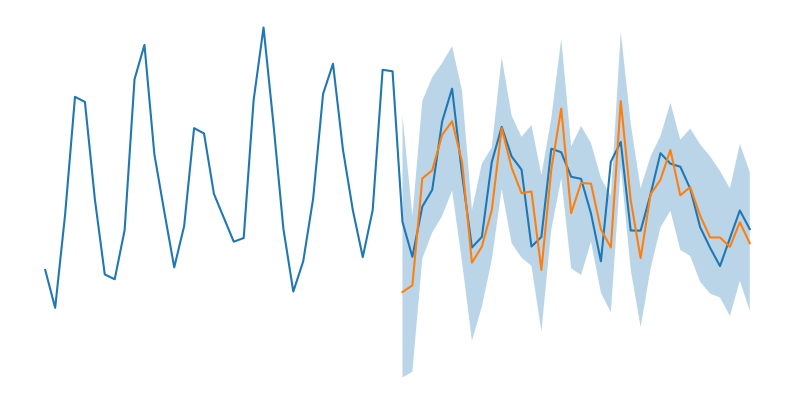

In [ ]:
# Visualize
target_to_vis = 0
num_vis = 1
num_rollouts = 50 if probabilistic else 1

best_model.eval()

with torch.no_grad():
    
    batch_enc_inputs, batch_dec_inputs, batch_dec_targets, scalers = next(batch_generator(data_to_eval, num_vis))
    
    outputs = []
    for r in range(num_rollouts):
        mo = best_model(batch_enc_inputs, batch_dec_inputs)
        output = Seq2Seq.sample_from_output(mo)
        outputs.append(output)
    outputs = torch.stack(outputs, dim=1)
    print(outputs.shape)

for indx in range(batch_enc_inputs.shape[0]):
    # scaler = scalers[indx]
    sample_enc_inputs, sample_dec_inputs, sample_dec_targets = \
        (batch_enc_inputs[indx])[:, target_to_vis].cpu().numpy().tolist(),\
            (batch_dec_inputs[indx])[:, target_to_vis].cpu().numpy().tolist(), \
                (batch_dec_targets[indx])[:, target_to_vis].cpu().numpy().tolist()
    output_rollouts = []
    for output_rollout in outputs[indx]:
        output_rollouts.append((output_rollout)[:, target_to_vis].cpu().numpy().tolist())
    output_rollouts = np.array(output_rollouts)

    plt.figure(figsize=(10,5))
    x = list(range(len(sample_enc_inputs) + len(sample_dec_targets)))
    # Plot inputs
    plt.plot(x, sample_enc_inputs + sample_dec_targets)
    # Plot median
    output_x = list(range(len(sample_enc_inputs), len(x)))
    print(output_x)
    plt.plot(output_x, np.median(output_rollouts, axis=0))
    # Plot quantiles
    plt.fill_between(
        output_x,
        np.quantile(output_rollouts, 0.05, axis=0), 
        np.quantile(output_rollouts, 0.95, axis=0), 
        alpha=0.3, 
        interpolate=True
    )
    plt.gca().set_axis_off()
    plt.show()


## RNN

In [15]:
class SimpleRnn(nn.Module):
  def __init__(self, in_d=2, out_d=2, hidden_d=4, num_hidden=1):
    super(SimpleRnn, self).__init__()
    self.rnn = nn.RNN(input_size=in_d, hidden_size=hidden_d, num_layers=num_hidden)
    self.fc = nn.Linear(hidden_d, out_d)

  def forward(self, x, h0):
    r, h = self.rnn(x, h0)
    # r = r[:, -1,:]
    y = self.fc(r)  # no activation on the output
    return y, h
rnn = SimpleRnn(input_size, output_size, hidden_size, num_layers).to(device)

## LSTM

For optional LSTM-GAN, see https://discuss.pytorch.org/t/how-to-use-lstm-to-construct-gan/12419

Or VAE (variational Auto encoder):

> The only constraint on the latent vector representation for traditional autoencoders is that latent vectors should be easily decodable back into the original image. As a result, the latent space $Z$ can become disjoint and non-continuous. Variational autoencoders try to solve this problem. [Alexander van de Kleut](https://avandekleut.github.io/vae/)

For LSTM based generative VAE: https://github.com/Khamies/LSTM-Variational-AutoEncoder/blob/main/model.py

http://web.archive.org/web/20210119121802/https://towardsdatascience.com/time-series-generation-with-vae-lstm-5a6426365a1c?gi=29d8b029a386

https://youtu.be/qJeaCHQ1k2w?si=30aAdqqwvz0DpR-x&t=687 VAE generate mu and sigma of a Normal distribution. Thus, they don't map the input to a single point, but a gausian distribution.

In [328]:
class LSTMModel(nn.Module):
    # input_size : number of features in input at each time step
    # hidden_size : Number of LSTM units 
    # num_layers : number of LSTM layers 
    def __init__(self, input_size, hidden_size, num_layers): 
        super(LSTMModel, self).__init__() #initializes the parent class nn.Module
        # We _could_ train the h0: https://discuss.pytorch.org/t/learn-initial-hidden-state-h0-for-rnn/10013 
        # self.lin1 = nn.Linear(input_size, hidden_size)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
        # self.activation_v = nn.LeakyReLU(.01)
        # self.activation_heading = torch.remainder()

    
    def get_hidden_state(self, batch_size, device):
        h = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        return (h, c)

    def forward(self, x, hidden_state): # defines forward pass of the neural network
        # out = self.lin1(x)
        
        out, hidden_state = self.lstm(x, hidden_state)
        # extract only the last time step, see https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/
        # print(out.shape)
        # TODO)) Might want to remove this below: as it might improve training
        # out = out[:, -1,:]
        # print(out.shape)
        out = self.linear(out)
        
        #  torch.remainder(out[1], 360)
        # print('o',out.shape)
        return out, hidden_state

lstm = LSTMModel(input_size, hidden_size, num_layers).to(device)


In [329]:
# model = rnn
model = lstm


In [330]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

In [331]:
def evaluate():
    # toggle evaluation mode
    model.eval()
    with torch.no_grad():
        batch_size, seq_len, feature_dim = X_train.shape
        y_pred, _ = model(
            X_train.to(device=device),
            model.get_hidden_state(batch_size, device)
            )
        train_rmse = torch.sqrt(loss_fn(y_pred, y_train))
        # print(y_pred)

        batch_size, seq_len, feature_dim = X_test.shape
        y_pred, _ = model(
            X_test.to(device=device),
            model.get_hidden_state(batch_size, device)
            )
        # print(loss_fn(y_pred, y_test))
        test_rmse = torch.sqrt(loss_fn(y_pred, y_test))
    print("Epoch ??: train RMSE %.4f, test RMSE %.4f" % ( train_rmse, test_rmse))

def load_most_recent():
    paths = list(cache_path.glob(f"checkpoint-{model._get_name()}_*.pt"))
    if len(paths) < 1:
        print('Nothing found to load')
        return None, None
    paths.sort()

    print(f"Loading {paths[-1]}")
    return load_cache(path=paths[-1])

def load_cache(epoch=None, path=None):
    if path is None:
        if epoch is None:
            raise RuntimeError("Either path or epoch must be given")
        path = cache_path / f"checkpoint-{model._get_name()}_{epoch:05d}.pt"
    else:
        print (path.stem)
        epoch = int(path.stem[-5:])

    cached = torch.load(path)
    
    optimizer.load_state_dict(cached['optimizer_state_dict'])
    model.load_state_dict(cached['model_state_dict'])
    return epoch, cached['loss']
    

def cache(epoch, loss):
    path = cache_path / f"checkpoint-{model._get_name()}_{epoch:05d}.pt"
    print(f"Cache to {path}")
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, path)


TODO)) See [this notebook](https://www.cs.toronto.edu/~lczhang/aps360_20191/lec/w08/rnn.html) For initialization (with random or not) and the use of GRU

In [332]:
start_epoch, loss = load_most_recent()
if start_epoch is None:
    start_epoch = 0
else:
    print(f"starting from epoch {start_epoch} (loss: {loss})")
    evaluate()

loss_log = []
# Train Network
for epoch in tqdm(range(start_epoch+1,num_epochs+1)):
    # toggle train mode
    model.train()
    for batch_idx, (x, targets) in enumerate(loader_train):
        # Get x to cuda if possible
        x = x.to(device=device).squeeze(1)
        targets = targets.to(device=device)

        # forward
        scores, _ = model(
            x,
            torch.zeros(num_layers, x.shape[2], hidden_size, dtype=torch.float).to(device=device),
            torch.zeros(num_layers, x.shape[2], hidden_size, dtype=torch.float).to(device=device)
            )
        # print(scores)
        loss = loss_fn(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent update step/adam step
        optimizer.step()

        loss_log.append(loss.item())

    if epoch % 5 != 0:
        continue

    cache(epoch, loss)
    evaluate()

evaluate()

Loading EXPERIMENTS/cache/hof2/checkpoint-LSTMModel_01000.pt
checkpoint-LSTMModel_01000
starting from epoch 1000 (loss: 0.014368701726198196)
Epoch ??: train RMSE 0.0849, test RMSE 0.0866


0it [00:00, ?it/s]

Epoch ??: train RMSE 0.0849, test RMSE 0.0866


In [333]:
# print(loss)
# print(len(loss_log))
# plt.plot(loss_log)
# plt.ylabel('Loss')
# plt.xlabel('iteration')
# plt.show()

In [335]:
model.eval()

with torch.no_grad():
    y_pred, _ = model(X_train.to(device=device),
                      model.get_hidden_state(X_train.shape[0], device))
    
    print(y_pred.shape, y_train.shape)
# y_train, y_pred

torch.Size([49999, 9, 2]) torch.Size([49999, 9, 2])


In [336]:
import scipy

def ceil_away_from_0(a):
    return np.sign(a) * np.ceil(np.abs(a))


In [343]:
def predict_and_plot(model, feature, steps = 50):
    lenght = feature.shape[0]

    dt = (1/ FPS) * SAMPLE_STEP

    trajectory = feature

    # feature = filtered_data.loc[_track_id,:].iloc[:5][in_fields].values
    # nxt = filtered_data.loc[_track_id,:].iloc[5][out_fields]
    with torch.no_grad():
        # h = torch.zeros(num_layers, window+1, hidden_size, dtype=torch.float).to(device=device)
        # c = torch.zeros(num_layers, window+1, hidden_size, dtype=torch.float).to(device=device)
        h = torch.zeros(num_layers, 1, hidden_size, dtype=torch.float).to(device=device)
        c = torch.zeros(num_layers, 1, hidden_size, dtype=torch.float).to(device=device)
        hidden_state = (h, c)
        # X = torch.tensor([feature], dtype=torch.float).to(device)
        # y, (h, c) = model(X, h, c)
        for i in range(steps):
            # predict_f = scipy.ndimage.uniform_filter(feature)
            # predict_f = scipy.interpolate.splrep(feature[:][0], feature[:][1],)
            # predict_f = scipy.signal.spline_feature(feature, lmbda=.1)
            # bathc size of one, so feature as single item in array
            # print(X.shape)
            X = torch.tensor([feature], dtype=torch.float).to(device)
            # print(type(model))
            y, hidden_state, *_ = model(X, hidden_state)
            # print(hidden_state.shape)

            s = y[-1][-1].cpu()

            #  proj_x    proj_y         v     heading          a    d_heading
            # next_step = feature

            dx, dy = s
            
            dx = (dx * GRID_SIZE).round() / GRID_SIZE
            dy = (dy * GRID_SIZE).round() / GRID_SIZE
            vx, vy = dx / dt, dy / dt

            v = np.sqrt(s[0]**2 + s[1]**2)
            heading = (np.arctan2(s[1], s[0])  * 180 / np.pi) % 360
            # a = (v - feature[-1][2]) / dt
            ax = (vx - feature[-1][2]) / dt
            ay = (vx - feature[-1][3]) / dt
            # d_heading = (heading - feature[-1][5])
            # print(s)
            # ['x', 'y', 'vx', 'vy', 'ax', 'ay'] 
            x = feature[-1][0] + dx
            y = feature[-1][1] + dy
            if GRID_SIZE is not None:
                # put points back on grid
                x = (x*GRID_SIZE).round() / GRID_SIZE
                y = (y*GRID_SIZE).round() / GRID_SIZE

            feature = [[x, y, vx, vy, ax, ay]]
            
            trajectory = np.append(trajectory, feature, axis=0)
            # f = [feature[-1][0] + s[0]*dt, feature[-1][1] + s[1]*dt, v, heading, a, d_heading ]
            # feature  = np.append(feature, [feature], axis=0)
            
            # print(next_step, nxt)
    # print(trajectory)
    plt.plot(trajectory[:lenght,0], trajectory[:lenght,1], c='orange')
    plt.plot(trajectory[lenght-1:,0], trajectory[lenght-1:,1], c='red')
    plt.scatter(trajectory[lenght:,0], trajectory[lenght:,1], c='red', marker='x')

1301
(10, 6) (10, 6)


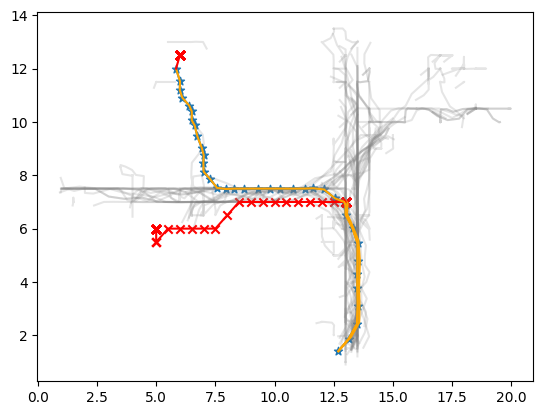

In [ ]:

# print(filtered_data.loc[track_id,:]['proj_x'])
_track_id =  8701 # random.choice(track_ids)
_track_id =  3880 # random.choice(track_ids)

# _track_id = 2780

for batch_idx in range(100):
    _track_id = random.choice(track_ids)
    plt.plot(
        data.loc[_track_id,:]['x'],
        data.loc[_track_id,:]['y'],
        c='grey', alpha=.2
    )

_track_id = random.choice(track_ids)
# _track_id = 1096
_track_id = 1301
print(_track_id)
ax = plt.scatter(
    data.loc[_track_id,:]['x'],
    data.loc[_track_id,:]['y'],
    marker="*") 
plt.plot(
    data.loc[_track_id,:]['x'],
    data.loc[_track_id,:]['y']
)

X = data.loc[_track_id,:].iloc[:][in_fields].values
# Adding randomness might be a cheat to get multiple features from current position
rnd = np.random.random_sample(X.shape) / 10
# print(rnd)

print(X[:10].shape, (X[:10] + rnd[:10]).shape)

# predict_and_plot(data.loc[_track_id,:].iloc[:5][in_fields].values)
# predict_and_plot(model, data.loc[_track_id,:].iloc[:5][in_fields].values, 50)
# predict_and_plot(model, data.loc[_track_id,:].iloc[:10][in_fields].values, 50)
# predict_and_plot(model, data.loc[_track_id,:].iloc[:20][in_fields].values)
# predict_and_plot(model, data.loc[_track_id,:].iloc[:30][in_fields].values)
predict_and_plot(model, X[:12])
predict_and_plot(model, X[:12] + rnd[:12])
predict_and_plot(model, data.loc[_track_id,:].iloc[:][in_fields].values)
# predict_and_plot(filtered_data.loc[_track_id,:].iloc[:70][in_fields].values)
# predict_and_plot(filtered_data.loc[_track_id,:].iloc[:115][in_fields].values)

## VAE

In [ ]:
# From https://github.com/CUN-bjy/lstm-vae-torch/blob/main/src/models.py (MIT)

from typing import Optional


class Encoder(nn.Module):
    def __init__(self, input_size=4096, hidden_size=1024, num_layers=2):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=False,
        )

    def get_hidden_state(self, batch_size, device):
        h = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        return (h, c)

    def forward(self, x, hidden_state):
        # x: tensor of shape (batch_size, seq_length, hidden_size)
        outputs, (hidden, cell) = self.lstm(x, hidden_state)
        return outputs, (hidden, cell)


class Decoder(nn.Module):
    def __init__(
        self, input_size=4096, hidden_size=1024, output_size=4096, num_layers=2
    ):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=False,
        )
        self.fc = nn.Linear(hidden_size, output_size)
    
    def get_hidden_state(self, batch_size, device):
        h = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        return (h, c)

    def forward(self, x, hidden):
        # x: tensor of shape (batch_size, seq_length, hidden_size)
        output, (hidden, cell) = self.lstm(x, hidden)
        prediction = self.fc(output)
        return prediction, (hidden, cell)


class LSTMVAE(nn.Module):
    """LSTM-based Variational Auto Encoder"""

    def __init__(
        self, input_size, output_size, hidden_size, latent_size, device=torch.device("cuda")
    ):
        """
        input_size: int, batch_size x sequence_length x input_dim
        hidden_size: int, output size of LSTM AE
        latent_size: int, latent z-layer size
        num_lstm_layer: int, number of layers in LSTM
        """
        super(LSTMVAE, self).__init__()
        self.device = device

        # dimensions
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.num_layers = 1

        # lstm ae
        self.lstm_enc = Encoder(
            input_size=input_size, hidden_size=hidden_size, num_layers=self.num_layers
        )
        self.lstm_dec = Decoder(
            input_size=latent_size,
            output_size=output_size,
            hidden_size=hidden_size,
            num_layers=self.num_layers,
        )

        self.fc21 = nn.Linear(self.hidden_size, self.latent_size)
        self.fc22 = nn.Linear(self.hidden_size, self.latent_size)
        self.fc3 = nn.Linear(self.latent_size, self.hidden_size)

    def reparametize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        noise = torch.randn_like(std).to(self.device)

        z = mu + noise * std
        return z

    def forward(self, x, hidden_state_encoder: Optional[tuple]=None):
        batch_size, seq_len, feature_dim = x.shape

        if hidden_state_encoder is None:
            hidden_state_encoder = self.lstm_enc.get_hidden_state(batch_size, self.device)

        # encode input space to hidden space
        prediction, hidden_state = self.lstm_enc(x, hidden_state_encoder)
        enc_h = hidden_state[0].view(batch_size, self.hidden_size).to(self.device)

        # extract latent variable z(hidden space to latent space)
        mean = self.fc21(enc_h)
        logvar = self.fc22(enc_h)
        z = self.reparametize(mean, logvar)  # batch_size x latent_size

        # initialize hidden state as inputs
        h_ = self.fc3(z)
        
        # decode latent space to input space
        z = z.repeat(1, seq_len, 1)
        z = z.view(batch_size, seq_len, self.latent_size).to(self.device)

        # initialize hidden state
        hidden = (h_.contiguous(), h_.contiguous())
        # TODO)) the above is not the right dimensions, but this changes architecture
        hidden = self.lstm_dec.get_hidden_state(batch_size, self.device)
        reconstruct_output, hidden = self.lstm_dec(z, hidden)

        x_hat = reconstruct_output
        
        return x_hat, hidden_state, mean, logvar

    def loss_function(self, *args, **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        predicted = args[0]
        target = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = 0.00025  # Account for the minibatch samples from the dataset
        recons_loss = torch.nn.functional.mse_loss(predicted, target=target)

        kld_loss = torch.mean(
            -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp(), dim=1), dim=0
        )

        loss = recons_loss + kld_weight * kld_loss
        return {
            "loss": loss,
            "Reconstruction_Loss": recons_loss.detach(),
            "KLD": -kld_loss.detach(),
        }


In [303]:
vae = LSTMVAE(input_size, output_size, hidden_size,  1024, device=device)
vae.to(device)
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

In [304]:
def train_vae(model, train_loader, test_loader, max_iter, learning_rate):
    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    ## interation setup
    epochs = tqdm(range(max_iter // len(train_loader) + 1))
    epochs = tqdm(range(max_iter))

    ## training
    count = 0
    for epoch in epochs:
        model.train()
        optimizer.zero_grad()
        train_iterator = tqdm(
            enumerate(train_loader), total=len(train_loader), desc="training"
        )

        # if count > max_iter:
        #     print("max!")
        #     return model

        for batch_idx, (x, targets) in train_iterator:
            count += 1

            # future_data, past_data = batch_data

            ## reshape
            batch_size = x.size(0)
            example_size = x.size(1)
            # image_size = past_data.size(2), past_data.size(3)
            # past_data = (
            #     past_data.view(batch_size, example_size, -1).float().to(args.device) # flattens image, we don't need this
            # )
            # future_data = future_data.view(batch_size, example_size, -1).float().to(args.device)

            y, hidden_state, mean, logvar = model(x)

            # calculate vae loss
            # print(y.shape, targets.shape)
            losses = model.loss_function(y, targets, mean, logvar)
            mloss, recon_loss, kld_loss = (
                losses["loss"],
                losses["Reconstruction_Loss"],
                losses["KLD"],
            )

            # Backward and optimize
            optimizer.zero_grad()
            mloss.mean().backward()
            optimizer.step()

            train_iterator.set_postfix({"train_loss": float(mloss.mean())})
        print("train_loss", float(mloss.mean()), epoch)

        model.eval()
        eval_loss = 0
        test_iterator = tqdm(
            enumerate(test_loader), total=len(test_loader), desc="testing"
        )

        with torch.no_grad():
            for batch_idx, (x, targets) in test_iterator:
                # future_data, past_data = batch_data

                ## reshape
                batch_size = x.size(0)
                example_size = x.size(1)
                # past_data = (
                #     past_data.view(batch_size, example_size, -1).float().to(args.device)
                # )
                # future_data = future_data.view(batch_size, example_size, -1).float().to(args.device)

                y, hidden_state, mean, logvar = model(x)

                # calculate vae loss
                losses = model.loss_function(y, targets, mean, logvar)
                mloss, recon_loss, kld_loss = (
                    losses["loss"],
                    losses["Reconstruction_Loss"],
                    losses["KLD"],
                )

                eval_loss += mloss.mean().item()

                test_iterator.set_postfix({"eval_loss": float(mloss.mean())})

                # if batch_idx == 0:
                #     nhw_orig = past_data[0].view(example_size, image_size[0], -1)
                #     nhw_recon = recon_x[0].view(example_size, image_size[0], -1)
                #     imshow(nhw_orig.cpu(), f"orig{epoch}")
                #     imshow(nhw_recon.cpu(), f"recon{epoch}")
                    # writer.add_images(f"original{i}", nchw_orig, epoch)
                    # writer.add_images(f"reconstructed{i}", nchw_recon, epoch)

        eval_loss = eval_loss / len(test_loader)
        # writer.add_scalar("eval_loss", float(eval_loss), epoch)
        print("Evaluation Score : [{}]".format(eval_loss))

    print("Done :-)")
    return model

In [305]:
train_vae(vae, loader_train, loader_test, num_epochs, learning_rate*10)

  0%|          | 0/1000 [00:00<?, ?it/s]


RuntimeError: For batched 3-D input, hx and cx should also be 3-D but got (2-D, 2-D) tensors

1301


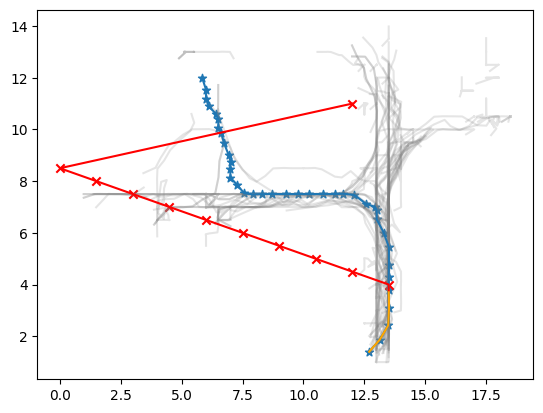

In [300]:
# VAE Predict and plot
_track_id =  8701 # random.choice(track_ids)
_track_id =  3880 # random.choice(track_ids)

# _track_id = 2780

for batch_idx in range(100):
    _track_id = random.choice(track_ids)
    plt.plot(
        data.loc[_track_id,:]['x'],
        data.loc[_track_id,:]['y'],
        c='grey', alpha=.2
    )

_track_id = random.choice(track_ids)
# _track_id = 1096
_track_id = 1301
print(_track_id)
ax = plt.scatter(
    data.loc[_track_id,:]['x'],
    data.loc[_track_id,:]['y'],
    marker="*") 
plt.plot(
    data.loc[_track_id,:]['x'],
    data.loc[_track_id,:]['y']
)

# predict_and_plot(data.loc[_track_id,:].iloc[:5][in_fields].values)
predict_and_plot(vae, data.loc[_track_id,:].iloc[:5][in_fields].values, 50)
# predict_and_plot(vae, data.loc[_track_id,:].iloc[:10][in_fields].values, 50)
# predict_and_plot(vae, data.loc[_track_id,:].iloc[:20][in_fields].values)
# predict_and_plot(vae, data.loc[_track_id,:].iloc[:30][in_fields].values)
# predict_and_plot(filtered_data.loc[_track_id,:].iloc[:70][in_fields].values)
# predict_and_plot(filtered_data.loc[_track_id,:].iloc[:115][in_fields].values)

In [ ]:
# import torch

class VAE_Loss(torch.nn.Module):
  """
  Adapted from https://github.com/Khamies/LSTM-Variational-AutoEncoder/blob/main/model.py
  """
  def __init__(self):
    super(VAE_Loss, self).__init__()
    self.nlloss = torch.nn.NLLLoss()
  
  def KL_loss (self, mu, log_var, z):
    kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    kl = kl.sum(-1)  # to go from multi-dimensional z to single dimensional z : (batch_size x latent_size) ---> (batch_size) 
                                                                      # i.e Z = [ [z1_1, z1_2 , ...., z1_lt] ] ------> z = [ z1] 
                                                                      #         [ [z2_1, z2_2, ....., z2_lt] ]             [ z2]
                                                                      #                   .                                [ . ]
                                                                      #                   .                                [ . ]
                                                                      #         [[zn_1, zn_2, ....., zn_lt] ]              [ zn]
                                                                      
                                                                      #        lt=latent_size 
    kl = kl.mean()
                                                                      
    return kl

  def reconstruction_loss(self, x_hat_param, x):

    x = x.view(-1).contiguous()
    x_hat_param = x_hat_param.view(-1, x_hat_param.size(2))

    recon = self.nlloss(x_hat_param, x)

    return recon
  

  def forward(self, mu, log_var,z, x_hat_param, x):
    kl_loss = self.KL_loss(mu, log_var, z)
    recon_loss = self.reconstruction_loss(x_hat_param, x)


    elbo = kl_loss + recon_loss # we use + because recon loss is a NLLoss (cross entropy) and it's negative in its own, and in the ELBO equation we have
                              # elbo = KL_loss - recon_loss, therefore, ELBO = KL_loss - (NLLoss) = KL_loss + NLLoss

    return elbo, kl_loss, recon_loss
  
class LSTM_VAE(torch.nn.Module):
  """
  Adapted from https://github.com/Khamies/LSTM-Variational-AutoEncoder/blob/main/model.py
  """
  def __init__(self, input_size, output_size, hidden_size, latent_size, num_layers=1, device="cuda"):
    super(LSTM_VAE, self).__init__()

    self.device = device
    
    # Variables
    self.num_layers = num_layers
    self.lstm_factor = num_layers
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.latent_size = latent_size
    self.output_size = output_size

    #    X: bsz * seq_len * vocab_size 
    #    X: bsz * seq_len * embed_size

    # Encoder Part
    self.encoder_lstm = torch.nn.LSTM(input_size= input_size,hidden_size= self.hidden_size, batch_first=True, num_layers= self.num_layers)
    self.mean = torch.nn.Linear(in_features= self.hidden_size * self.lstm_factor, out_features= self.latent_size)
    self.log_variance = torch.nn.Linear(in_features= self.hidden_size * self.lstm_factor, out_features= self.latent_size)

    # Decoder Part
                                        
    self.hidden_decoder_linear = torch.nn.Linear(in_features= self.latent_size, out_features= self.hidden_size * self.lstm_factor)
    self.decoder_lstm = torch.nn.LSTM(input_size= self.embed_size, hidden_size= self.hidden_size, batch_first = True, num_layers = self.num_layers)
    self.output = torch.nn.Linear(in_features= self.hidden_size * self.lstm_factor, out_features= self.output_size)
    # self.log_softmax = torch.nn.LogSoftmax(dim=2)

  def get_hidden_state(self, batch_size):
    h = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device)
    c = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device)
    return (h, c)


  def encoder(self, x, hidden_state):

    # pad the packed input.

    out, (h,c) = self.encoder_lstm(x, hidden_state)
    # output_encoder, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_output_encoder, batch_first=True, total_length= total_padding_length)

    # Extimate the mean and the variance of q(z|x)
    mean = self.mean(h)
    log_var = self.log_variance(h)
    std = torch.exp(0.5 * log_var)   # e^(0.5 log_var) = var^0.5
    
    # Generate a unit gaussian noise.
    # batch_size = output_encoder.size(0)
    # seq_len = output_encoder.size(1)
    # noise = torch.randn(batch_size, self.latent_size).to(self.device)
    noise = torch.randn(self.latent_size).to(self.device)
    
    z = noise * std + mean

    return z, mean, log_var, (h,c)


  def decoder(self, z, x):

    hidden_decoder = self.hidden_decoder_linear(z)
    hidden_decoder = (hidden_decoder, hidden_decoder)

    # pad the packed input.
    packed_output_decoder, hidden_decoder = self.decoder_lstm(packed_x_embed,hidden_decoder) 
    output_decoder, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_output_decoder, batch_first=True, total_length= total_padding_length)


    x_hat = self.output(output_decoder)
    
    # x_hat = self.log_softmax(x_hat)


    return x_hat

  

  def forward(self, x, hidden_state):
    
    """
      x : bsz * seq_len
    
      hidden_encoder: ( num_lstm_layers * bsz * hidden_size, num_lstm_layers * bsz * hidden_size)

    """
    # Get Embeddings
    # x_embed, maximum_padding_length = self.get_embedding(x)

    # Packing the input
    # packed_x_embed = torch.nn.utils.rnn.pack_padded_sequence(input= x_embed, lengths= sentences_length, batch_first=True, enforce_sorted=False)


    # Encoder
    z, mean, log_var, hidden_encoder = self.encoder(x, maximum_padding_length, hidden_encoder)

    # Decoder
    x_hat = self.decoder(z, packed_x_embed, maximum_padding_length)
    
    return x_hat, mean, log_var, z, hidden_encoder

  

  def inference(self, n_samples, x, z):

    # generate random z 
    batch_size = 1
    seq_len = 1
    idx_sample = []


    hidden = self.hidden_decoder_linear(z)
    hidden = (hidden, hidden)
    
    for i in range(n_samples):
      
      output,hidden = self.decoder_lstm(x, hidden)
      output = self.output(output)
      # output = self.log_softmax(output)
      # output = output.exp()
      _, s = torch.topk(output, 1)
      idx_sample.append(s.item())
      x = s.squeeze(0)

    w_sample = [self.dictionary.get_i2w()[str(idx)] for idx in idx_sample]
    w_sample = " ".join(w_sample)

    return w_sample



def get_batch(batch):
  sentences = batch["input"]
  target = batch["target"]
  sentences_length = batch["length"]

  return sentences, target, sentences_length

class Trainer:

    def __init__(self, train_loader, test_loader, model, loss, optimizer) -> None:
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.model = model
        self.loss = loss
        self.optimizer = optimizer
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.interval = 200


    def train(self, train_losses, epoch, batch_size, clip) -> list:  
        # Initialization of RNN hidden, and cell states.
        states = self.model.init_hidden(batch_size) 

        for batch_idx, (x, targets) in enumerate(self.train_loader):
            # Get x to cuda if possible
            x = x.to(device=device).squeeze(1)
            targets = targets.to(device=device)

        # for batch_num, batch in enumerate(self.train_loader): # loop over the data, and jump with step = bptt.
            # get the labels
            source, target, source_lengths = get_batch(batch)
            source = source.to(self.device)
            target = target.to(self.device)


            x_hat_param, mu, log_var, z, states = self.model(source,source_lengths, states)

            # detach hidden states
            states = states[0].detach(), states[1].detach()

            # compute the loss
            mloss, KL_loss, recon_loss = self.loss(mu = mu, log_var = log_var, z = z, x_hat_param = x_hat_param , x = target)

            train_losses.append((mloss , KL_loss.item(), recon_loss.item()))

            mloss.backward()

            torch.nn.utils.clip_grad_norm_(self.model.parameters(), clip)

            self.optimizer.step()

            self.optimizer.zero_grad()


            if batch_num % self.interval == 0 and batch_num > 0:
  
                print('| epoch {:3d} | elbo_loss {:5.6f} | kl_loss {:5.6f} | recons_loss {:5.6f} '.format(
                    epoch, mloss.item(), KL_loss.item(), recon_loss.item()))

        return train_losses

    def test(self, test_losses, epoch, batch_size) -> list:

        with torch.no_grad():

            states = self.model.init_hidden(batch_size) 

            for batch_num, batch in enumerate(self.test_loader): # loop over the data, and jump with step = bptt.
                # get the labels
                source, target, source_lengths = get_batch(batch)
                source = source.to(self.device)
                target = target.to(self.device)


                x_hat_param, mu, log_var, z, states = self.model(source,source_lengths, states)

                # detach hidden states
                states = states[0].detach(), states[1].detach()

                # compute the loss
                mloss, KL_loss, recon_loss = self.loss(mu = mu, log_var = log_var, z = z, x_hat_param = x_hat_param , x = target)

                test_losses.append((mloss , KL_loss.item(), recon_loss.item()))

                # Statistics.
                # if batch_num % 20 ==0:
                #   print('| epoch {:3d} | elbo_loss {:5.6f} | kl_loss {:5.6f} | recons_loss {:5.6f} '.format(
                #         epoch, mloss.item(), KL_loss.item(), recon_loss.item()))

            return test_losses

vae = LSTM_VAE(input_size, output_size, hidden_size, 16, 1, device).to(device)

vae_loss = VAE_Loss()
optimizer = torch.optim.Adam(vae.parameters(), lr= learning_rate)

trainer = Trainer(loader_train, loader_test, vae, vae_loss, optimizer)




AttributeError: 'LSTM_VAE' object has no attribute 'embed_size'